# RetinaNet Dev Notebook

This document is modified version of the [Fastai RetinaNet Dev Notebook](https://github.com/fastai/fastai_docs/blob/master/dev_nb/102a_coco.ipynb), so that it works with the latest library version.
Currently, the notebook runs until the learning part (included), but somehow the network doesn't seem to learn.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

## Create DataBunch and understand it

In [3]:
size = 256
bs = 4

In [4]:
path = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(path/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [5]:
lbl_bbox[0][0][0]

[86.34, 32.52, 95.75, 41.050000000000004]

In [6]:
data = (ObjectItemList.from_folder(path)
        #Where are the images? -> in coco
        .random_split_by_pct(seed=42)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), size=size, tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

In [7]:
data.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

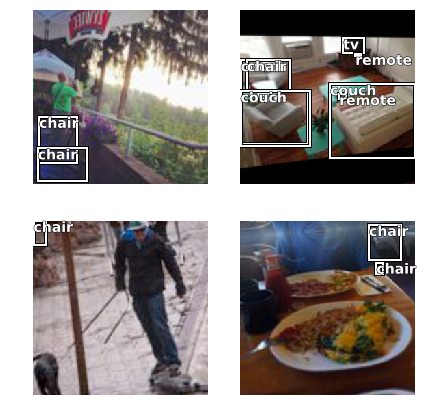

In [8]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(6,6))

In [9]:
databatch = data.one_batch()
xb,yb = databatch
print(xb.shape)
print(len(yb))
print(yb[0].shape)
print(yb[1].shape)

torch.Size([4, 3, 256, 256])
2
torch.Size([4, 13, 4])
torch.Size([4, 13])


In [10]:
print(yb[0][0,0,:])
print(yb[1][0,:])

tensor([0., 0., 0., 0.])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4])


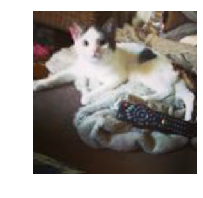

In [11]:
Image(xb[0]).show()

In [12]:
yb[1][0].nonzero()[:,0]

tensor([12])

In [13]:
yb[0][0][:,:]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1078, -0.0097,  0.5729,  0.9892]])

Although this function doesn't work, by looking at it, as well as the ImageBBox.create function, we understand that the bb labels are in \[-1,1\] and that they mean \[TLy,TLx,BRy,BRx\]

In [14]:
def show_sample(rows, start=0):
    x,y = data.one_batch()
    x = x[start:start+rows*rows].cpu()
    _,axs = plt.subplots(rows,rows,figsize=(9,9))
    for i, ax in enumerate(axs.flatten()):
        img = Image(x[i])
        idxs = y[1][start+i].nonzero()[:,0]
        
        if len(idxs) != 0:
            bbs,lbls = y[0][start+i][idxs],y[1][start+i][idxs]
            h,w = img.size
            bbs=bbs.cpu()
            lbls=lbls.cpu()
            bbs = ((bbs+1) * torch.tensor([h/2,w/2, h/2, w/2])).long()
            print(bbs.shape)
            bbox = ImageBBox.create(*img.size,bbs,lbls)
            img.show(ax=ax, y=bbox, classes=dl.dataset.classes)
        else: img.show(ax=ax)
    plt.tight_layout()

## Define the model

In [15]:
#export
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [16]:
encoder = create_body(models.resnet34, True, cut=-2)

In [17]:
#export
class LateralUpsampleMerge(nn.Module):
    
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, scale_factor=2)

In [18]:
from fastai.callbacks import *
import pdb

In [19]:
from torch.nn.modules.module import Module

In [20]:
#export
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        hooks = hook_outputs(encoder)    
#         sfs_szs,x,hooks = model_sizes(encoder, size=imsize)
        sfs_idxs = _get_sfs_idxs(sfs_szs)
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, szs[1], hook) 
                                     for szs,hook in zip(sfs_szs[-2:-4:-1], hooks[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        layers = [conv_layer(chs, chs, bias=True) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]

In [21]:
encoder = create_body(models.resnet50,pretrained=True, cut=-2)
model = RetinaNet(encoder, 6, -4) 
model.eval()
x = torch.randn(2,3,256,256)
output = model(x)

In [22]:
[y.size() for y in output[:2]], output[2]

([torch.Size([2, 12276, 6]), torch.Size([2, 12276, 4])],
 [[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]])

In [23]:
print(len(output))
print(output[0].shape)
print(output[1].shape)
print(output[2])


3
torch.Size([2, 12276, 6])
torch.Size([2, 12276, 4])
[[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]]


## Anchors

In [24]:
torch.arange(1,17).long().view(4,4)

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

In [25]:
#export
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [26]:
#export
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

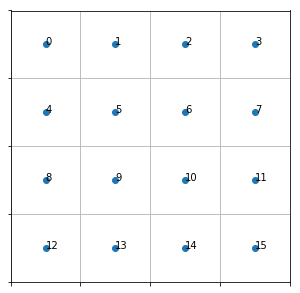

In [27]:
size = (4,4)
show_anchors(create_grid(size), size)

In [28]:
#export
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [29]:
ratios = [1/2,1,2]
#scales = [1,2**(-1/3), 2**(-2/3)]
scales = [1,2**(1/3), 2**(2/3)]
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse()
anchors = create_anchors(sizes, ratios, scales)

In [30]:
anchors.size()
#[anc.size() for anc in anchors]

torch.Size([3069, 4])

In [31]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [32]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

In [33]:
#export
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [34]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)

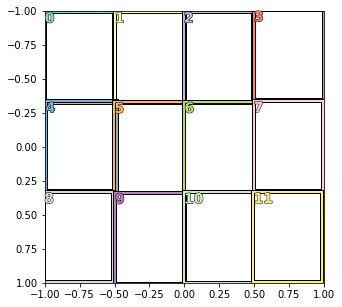

In [35]:
show_boxes(bboxes)

In [36]:
#export
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [37]:
#export
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

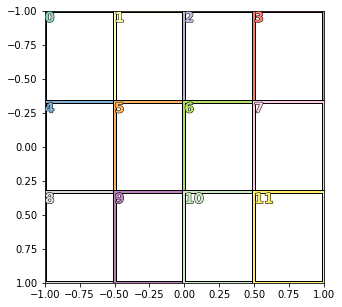

In [38]:
show_boxes(anchors)

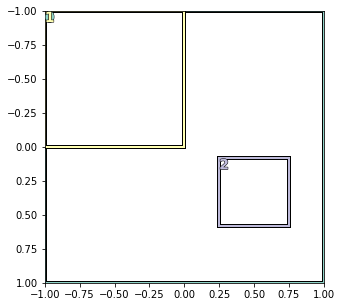

In [39]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [40]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [41]:
#export
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [42]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

In [43]:
#export
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    ious = IoU_values(anchors, targets)
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [44]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [45]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [46]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [47]:
#export
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [48]:
#export
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [49]:
#export
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [50]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [51]:
#export
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred)
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        #pdb.set_trace()
        weights_no_grad = weights.detach()
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights_no_grad, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [52]:
#export
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

In [53]:
LongTensor([[[0,0,64,128,0], [32,64,128,128,1]], [[128,96,256,192,2], [96,192,128,256,3]]]).float().cuda()

tensor([[[  0.,   0.,  64., 128.,   0.],
         [ 32.,  64., 128., 128.,   1.]],

        [[128.,  96., 256., 192.,   2.],
         [ 96., 192., 128., 256.,   3.]]], device='cuda:0')

In [54]:
tgt_clas = LongTensor([[1,2], [3,4]])
tgt_bbox = FloatTensor([[[0,0,128,64], [64,32,128,128]], [[96,128,192,256], [192,96,256,128]]])
tgt_bbox = tgt_bbox / 128 - 1.
y = [tgt_bbox.cuda(), tgt_clas.cuda()]

In [55]:
#export
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

## Training

In [56]:
model=None
encoder = None
gc.collect()

0

In [57]:
n_classes = 6
encoder = create_body(models.resnet50,True, -2)
model = RetinaNet(encoder, n_classes,final_bias=-4) 
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [58]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

In [63]:
# pdb.set_trace()
learn.lr_find(start_lr=1e-8)
learn.recorder.plot(skip_start=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: Traceback (most recent call last):
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/fastai/vision/data.py", line 42, in bb_pad_collate
    max_len = max([len(s[1].data[1]) for s in samples])
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/fastai/vision/data.py", line 42, in <listcomp>
    max_len = max([len(s[1].data[1]) for s in samples])
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/torch/tensor.py", line 411, in __len__
    raise TypeError("len() of a 0-d tensor")
TypeError: len() of a 0-d tensor


In [62]:
learn.fit_one_cycle(5, 1e-7)

epoch,train_loss,valid_loss
1,3.310924,3.079865


TypeError: Traceback (most recent call last):
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/fastai/vision/data.py", line 42, in bb_pad_collate
    max_len = max([len(s[1].data[1]) for s in samples])
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/fastai/vision/data.py", line 42, in <listcomp>
    max_len = max([len(s[1].data[1]) for s in samples])
  File "/home/pierre/anaconda3/envs/fastai_test/lib/python3.7/site-packages/torch/tensor.py", line 411, in __len__
    raise TypeError("len() of a 0-d tensor")
TypeError: len() of a 0-d tensor


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('sample')

## Inference

In [ ]:
learn.load('sample')

In [ ]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = model(img)

In [ ]:
torch.save(img, path/'models'/'tst_input.pth')

In [ ]:
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.3, classes=None):
    clas_pred,bbox_pred,sizes = output[0][idx].cpu(), output[1][idx].cpu(), output[2]
    anchors = create_anchors(sizes, ratios, scales)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
#     pdb.set_trace()
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    print(bbox_pred)
    _, ax = plt.subplots(1,1)
    
    if bbox_pred.shape[0]==0:
        img.show(ax=ax)
        return
    for bbox, c in zip(bbox_pred, clas_pred.argmax(1)):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=txt)

In [ ]:
idx = 0
img = data.valid_ds[idx][0]
print(img.shape)
classes = data.train_ds.classes
print(classes)
print(output[2])
show_preds(img, output, idx, detect_thresh=0.1, classes=classes)

In [ ]:
#export
def nms(boxes, scores, thresh=0.5):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        #pdb.set_trace()
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals <= thresh
        if len(mask_keep.nonzero()) == 0: break
        idx_first = mask_keep.nonzero().min().item()
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [ ]:
#export
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.25, classes=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [ ]:
idx = 0
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.2, classes=data.classes)

In [ ]:
#export
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [ ]:
get_predictions(output, 0)